## Imports and dataset

In [1]:
from src.models.conjugate_bayes_lin_reg import FlatPriorLinearRegression, NormalInverseGammaPriorLinearRegression, NormalKnownVariancePriorLinearRegression
from src.utils import get_toy_data, plot_ppds

from src.attacks.distr_attacks import fgsm_attack, mlmc_attack, mlmc_gradient_estimator, kl_div, kl_maximization

import numpy as np
import torch
from torch.optim import SGD
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

import time
from joblib import Parallel, delayed

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Wine dataset

In [4]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [5]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
# Add a column of ones for the bias term
# X_ones = np.c_[np.ones(X.shape[0]), X_normalized] 

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

## Case 1: Analytical attack - Max disruption

In [6]:
# Fit the model
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [7]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_distr, x_adv_values, kl_values = kl_maximization(model, x, epsilon=0.3)

Text(0, 0.5, 'KL Divergence')

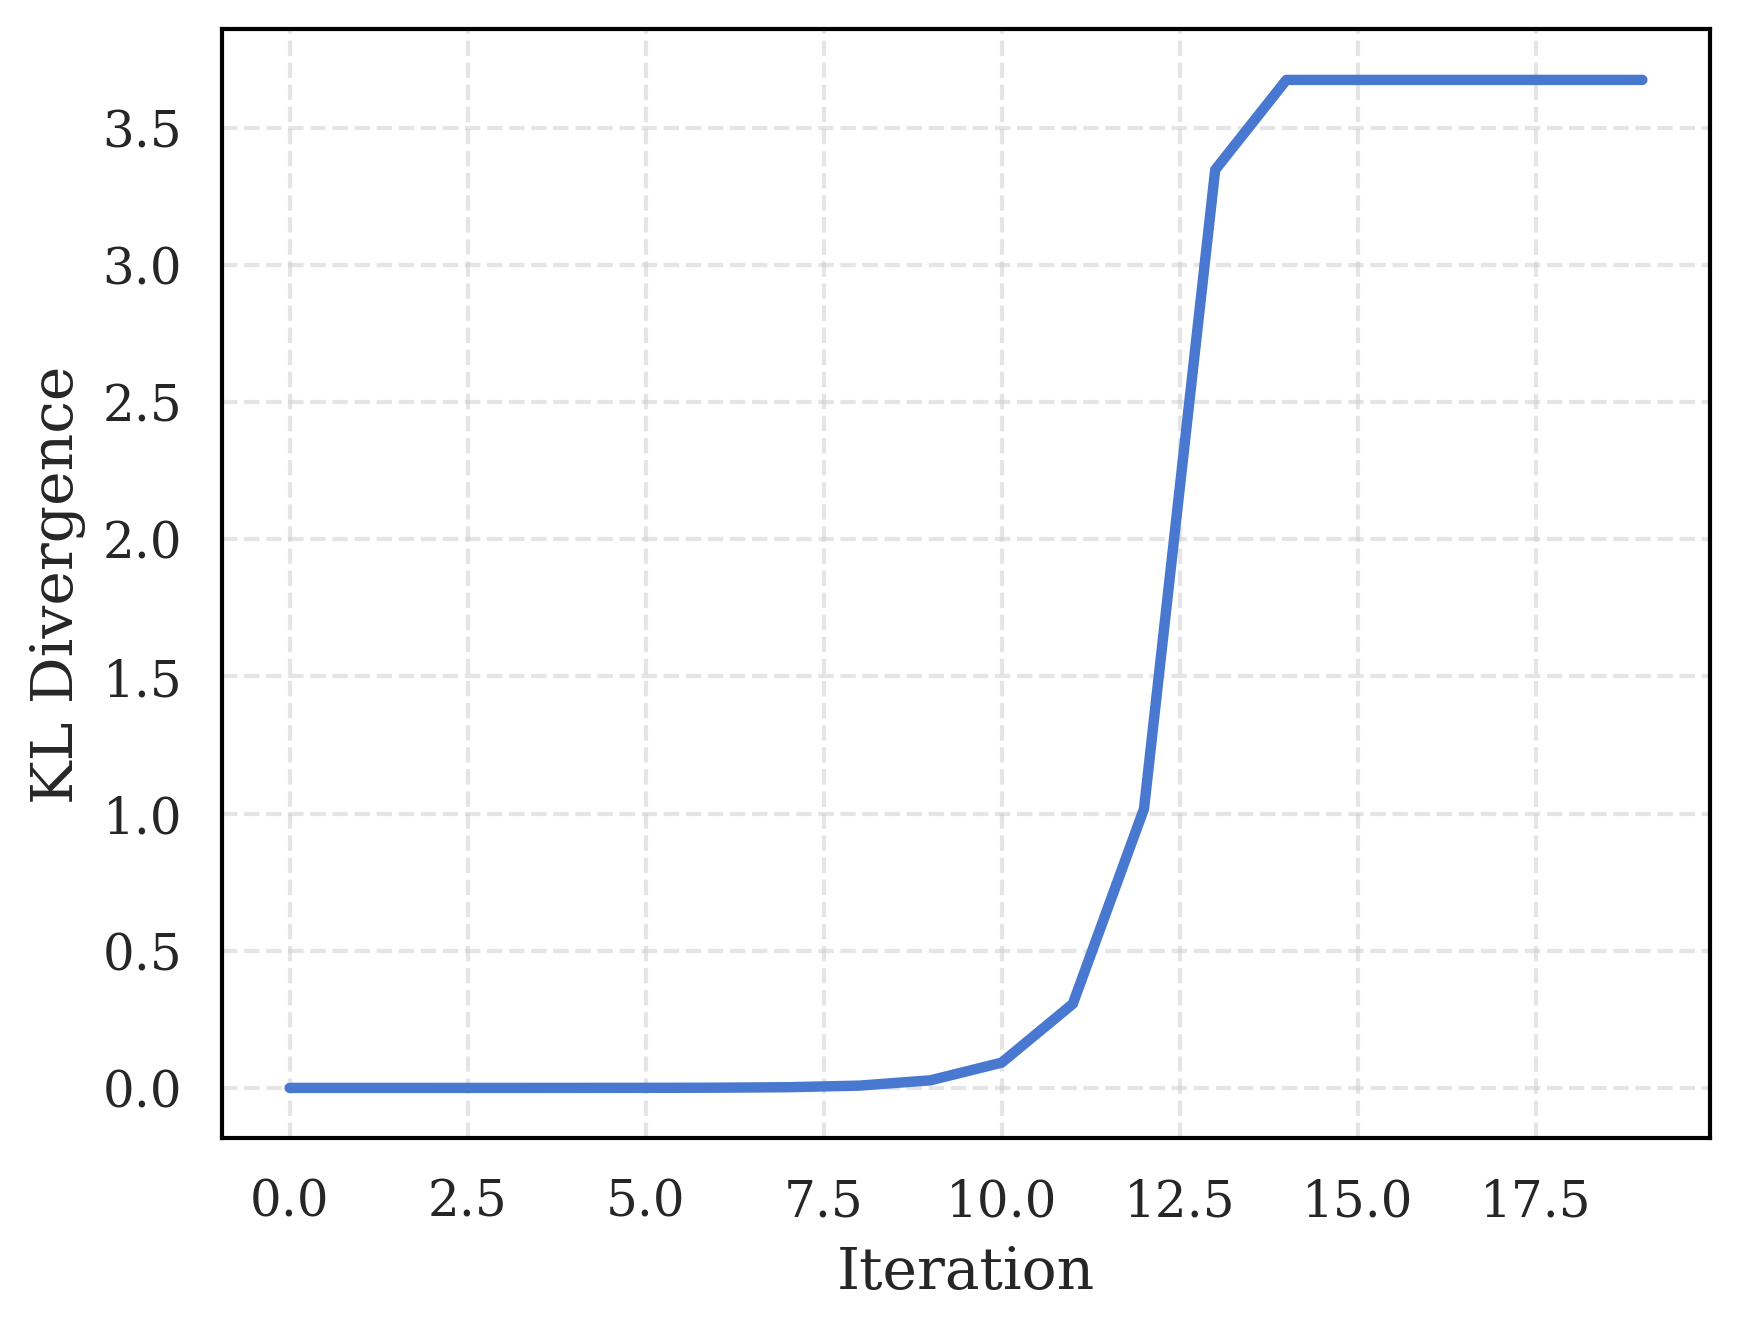

In [8]:
plt.plot(kl_values[:20])
plt.xlabel('Iteration')
plt.ylabel('KL Divergence')

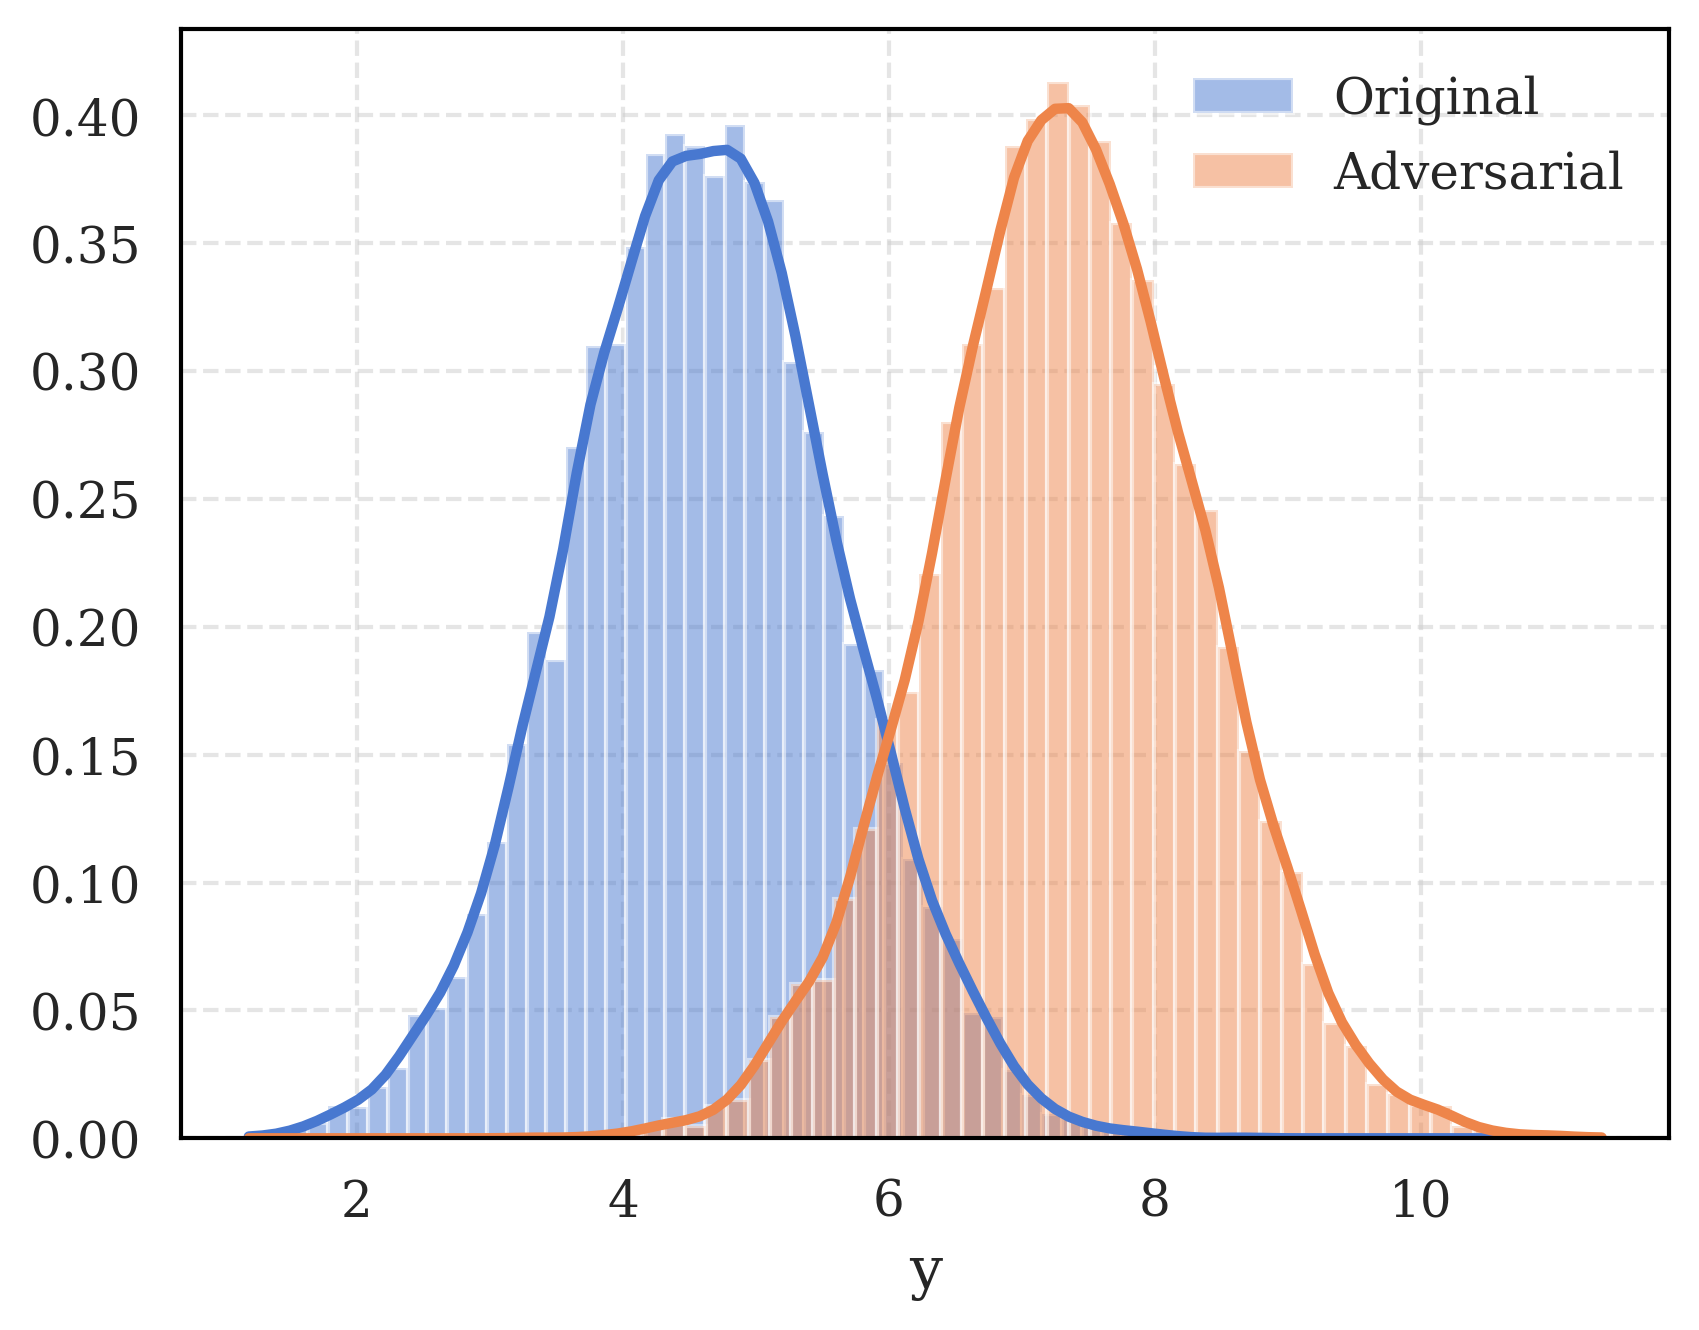

In [9]:
plot_ppds(model, x, x_adv_distr)

<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2939908/2771096520.py:16: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


Text(0, 0.5, 'KL Divergence')

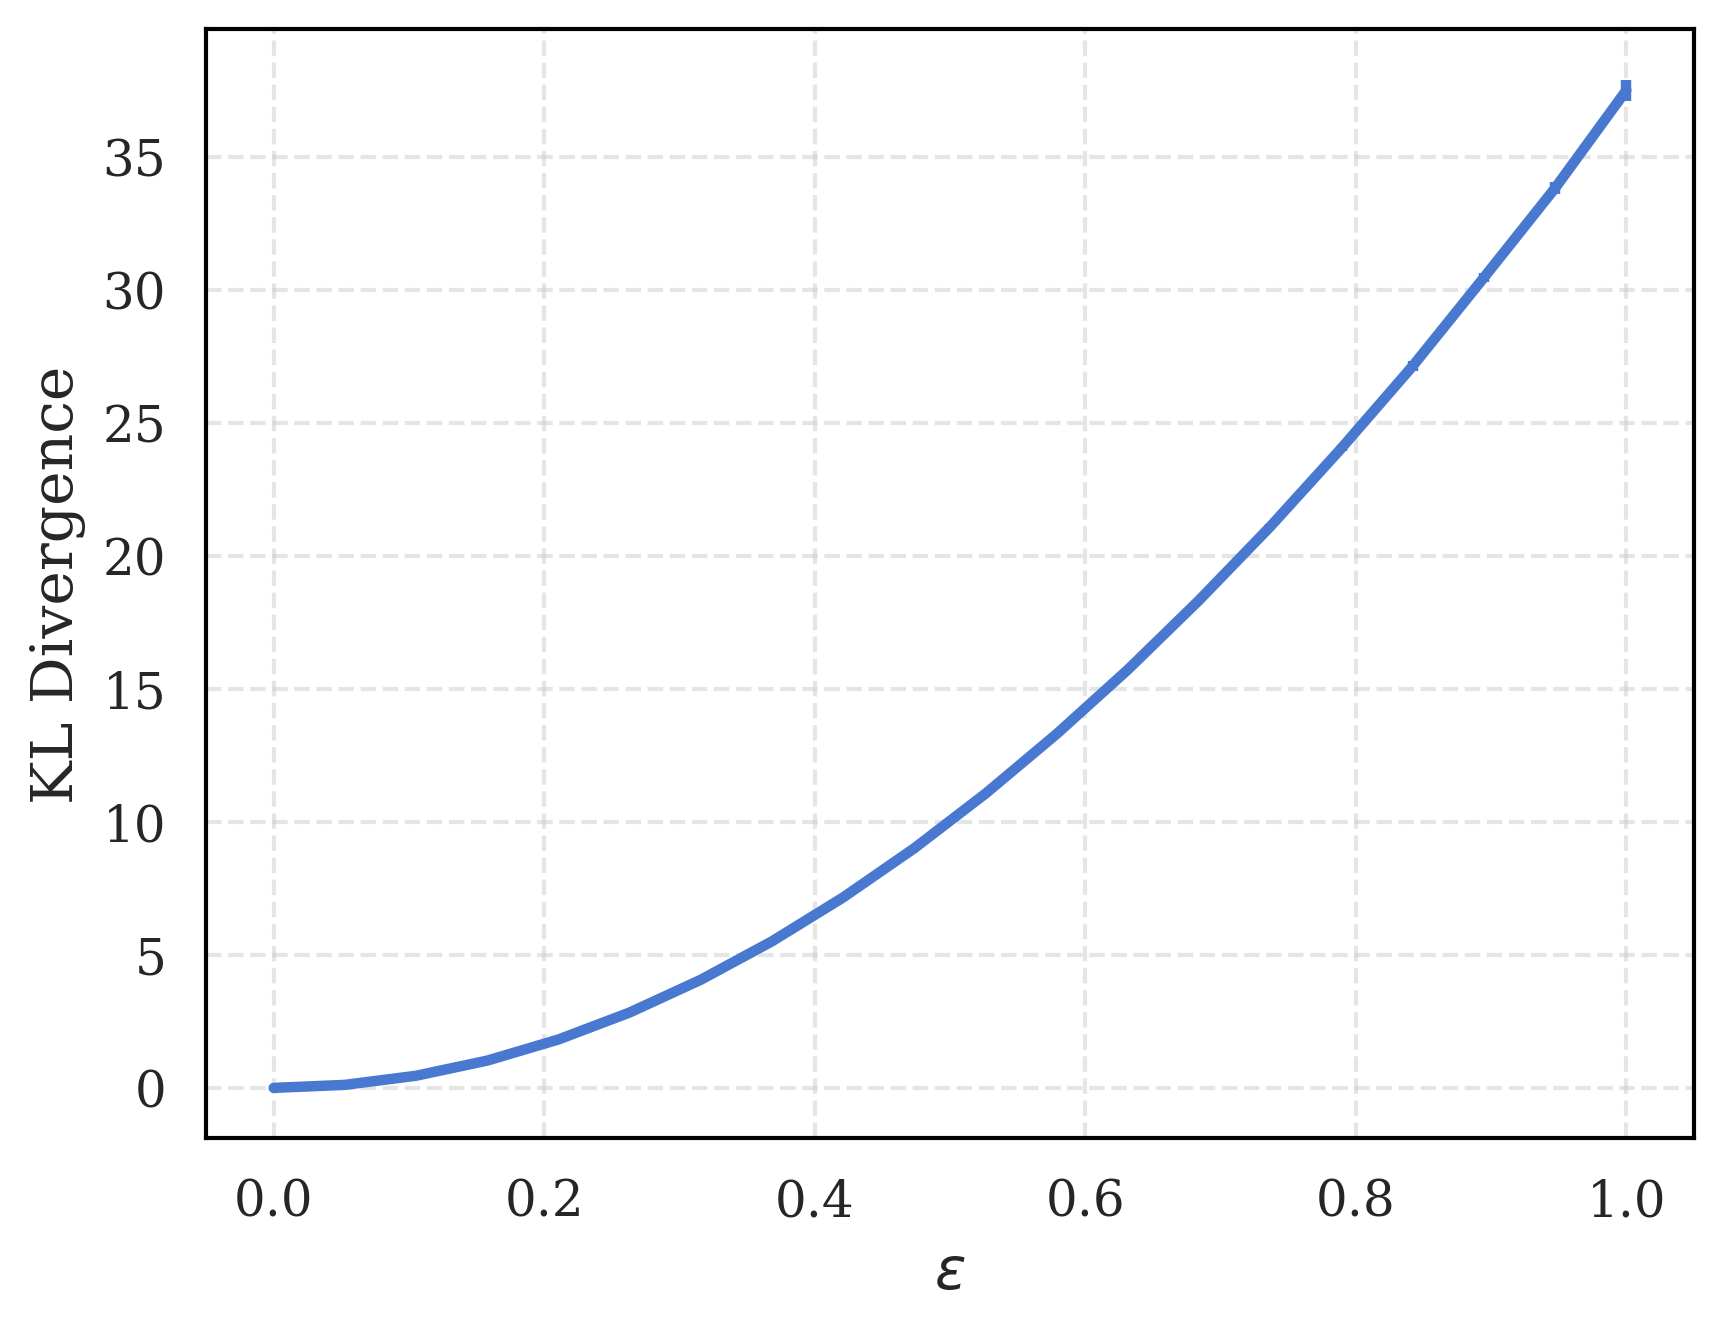

In [10]:
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)

kl_alls = []
epsilons = np.linspace(0, 1, 20)

for _ in range(10):
    kl_values = []
    for epsilon in epsilons:
        x_adv_distr, _, kl = kl_maximization(model, x, epsilon=epsilon)
        kl_values.append(kl[-1])
    kl_alls.append(kl_values)

# std as error bars
plt.errorbar(epsilons, np.mean(kl_alls, axis=0), yerr=2*np.std(kl_alls, axis=0))
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')

## Case 2: SGD attack

### Case 2a: NormalInverseGamma model

In [11]:
# Fit the model
model = NormalInverseGammaPriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'a': torch.tensor([10]), 
    'b': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

/home/pgarcia/AdvReg/src/models/conjugate_bayes_lin_reg.py:119: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724788957849/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  b_n = self.b + 0.5 * (y.T @ y + self.mu.T @ self.lam @ self.mu - mu_n.T @ lam_n @ mu_n)


Long gradient estimation time: 4.347812652587891 for iteration 0
Long gradient estimation time: 2.5194828510284424 for iteration 156


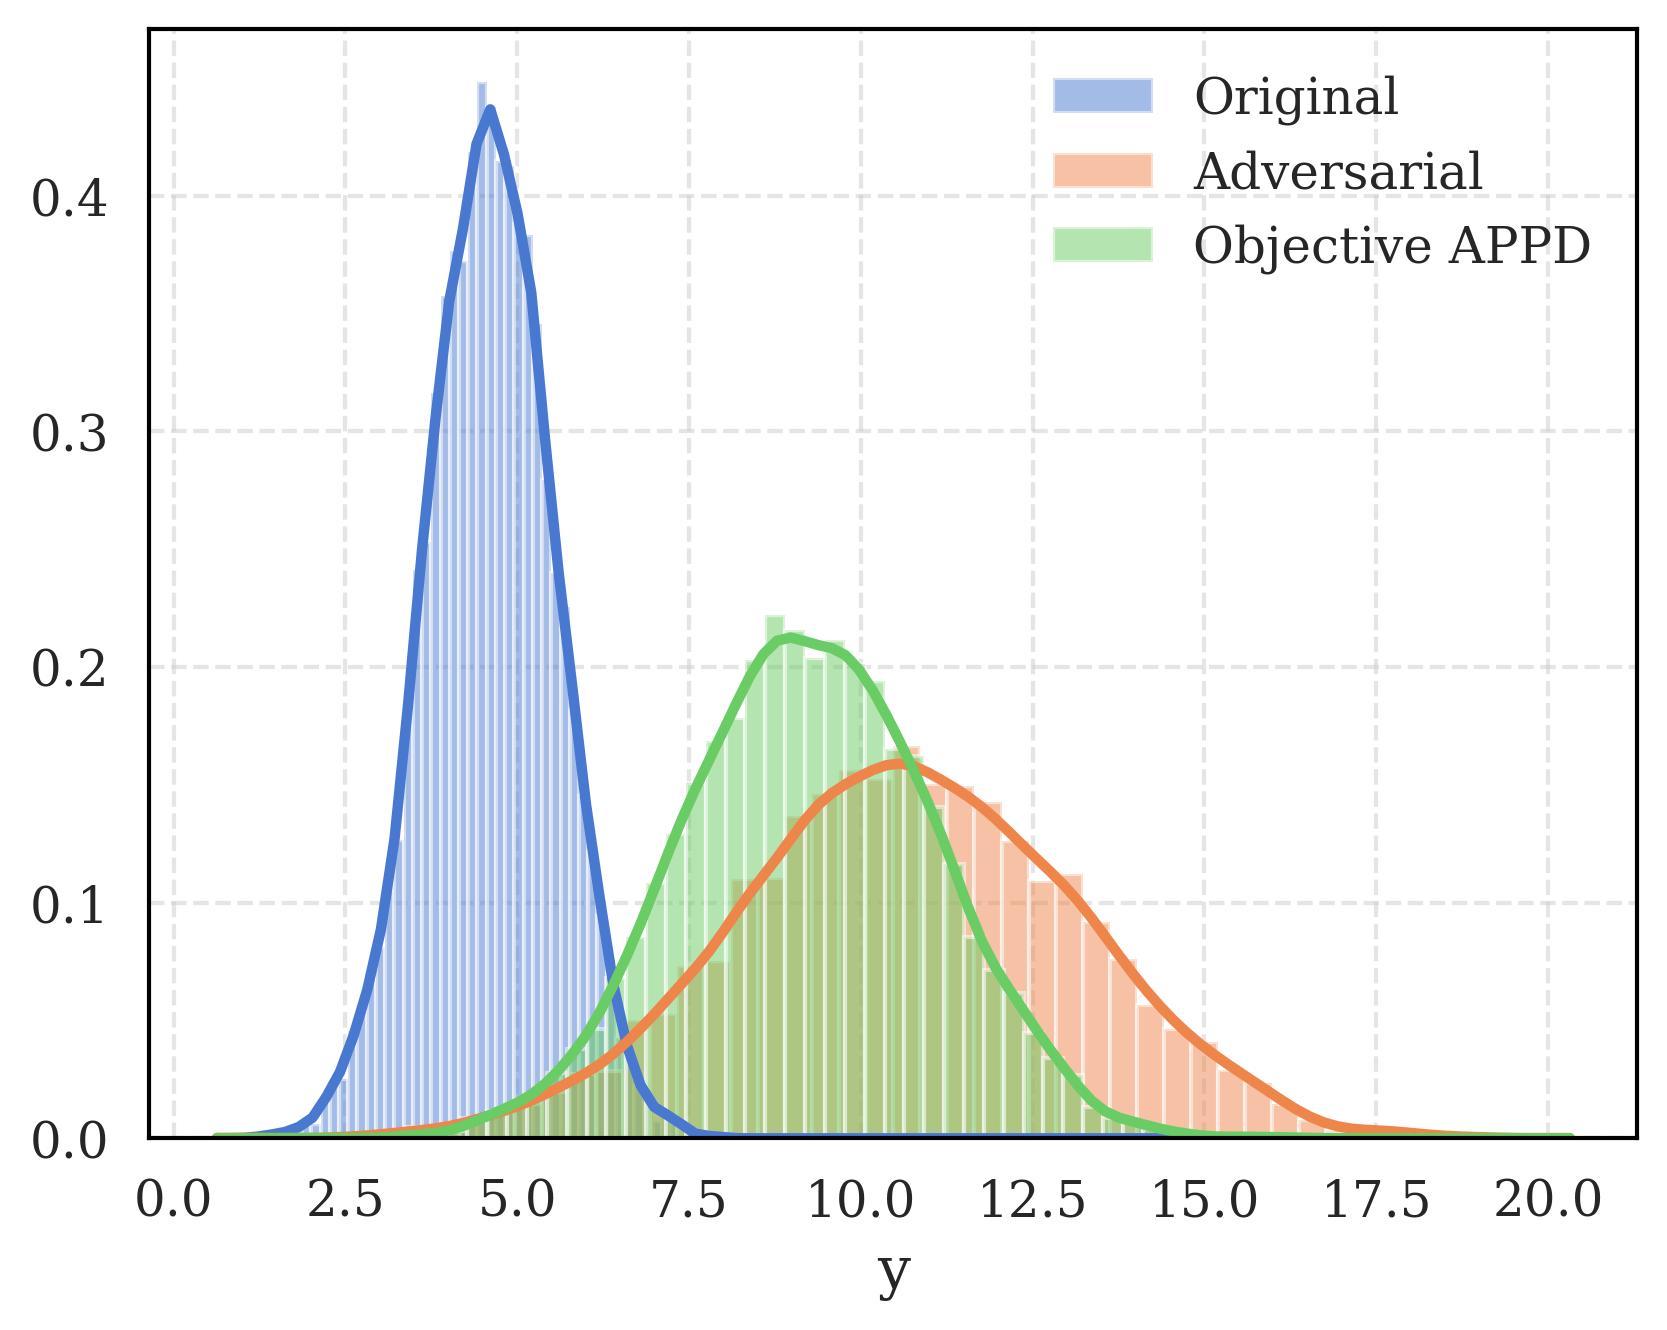

In [12]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
sigma2 = model.sample_posterior_distribution(1000)[1].mean()
appd = torch.distributions.normal.Normal(2 * x.T @ model.mu, 2 * sigma2)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=5, R=100, lr=0.01, n_iter=200)
plot_ppds(model, x, x_adv_distr, appd)

Long gradient estimation time: 2.4892923831939697 for iteration 10
Early stopping at iteration 12


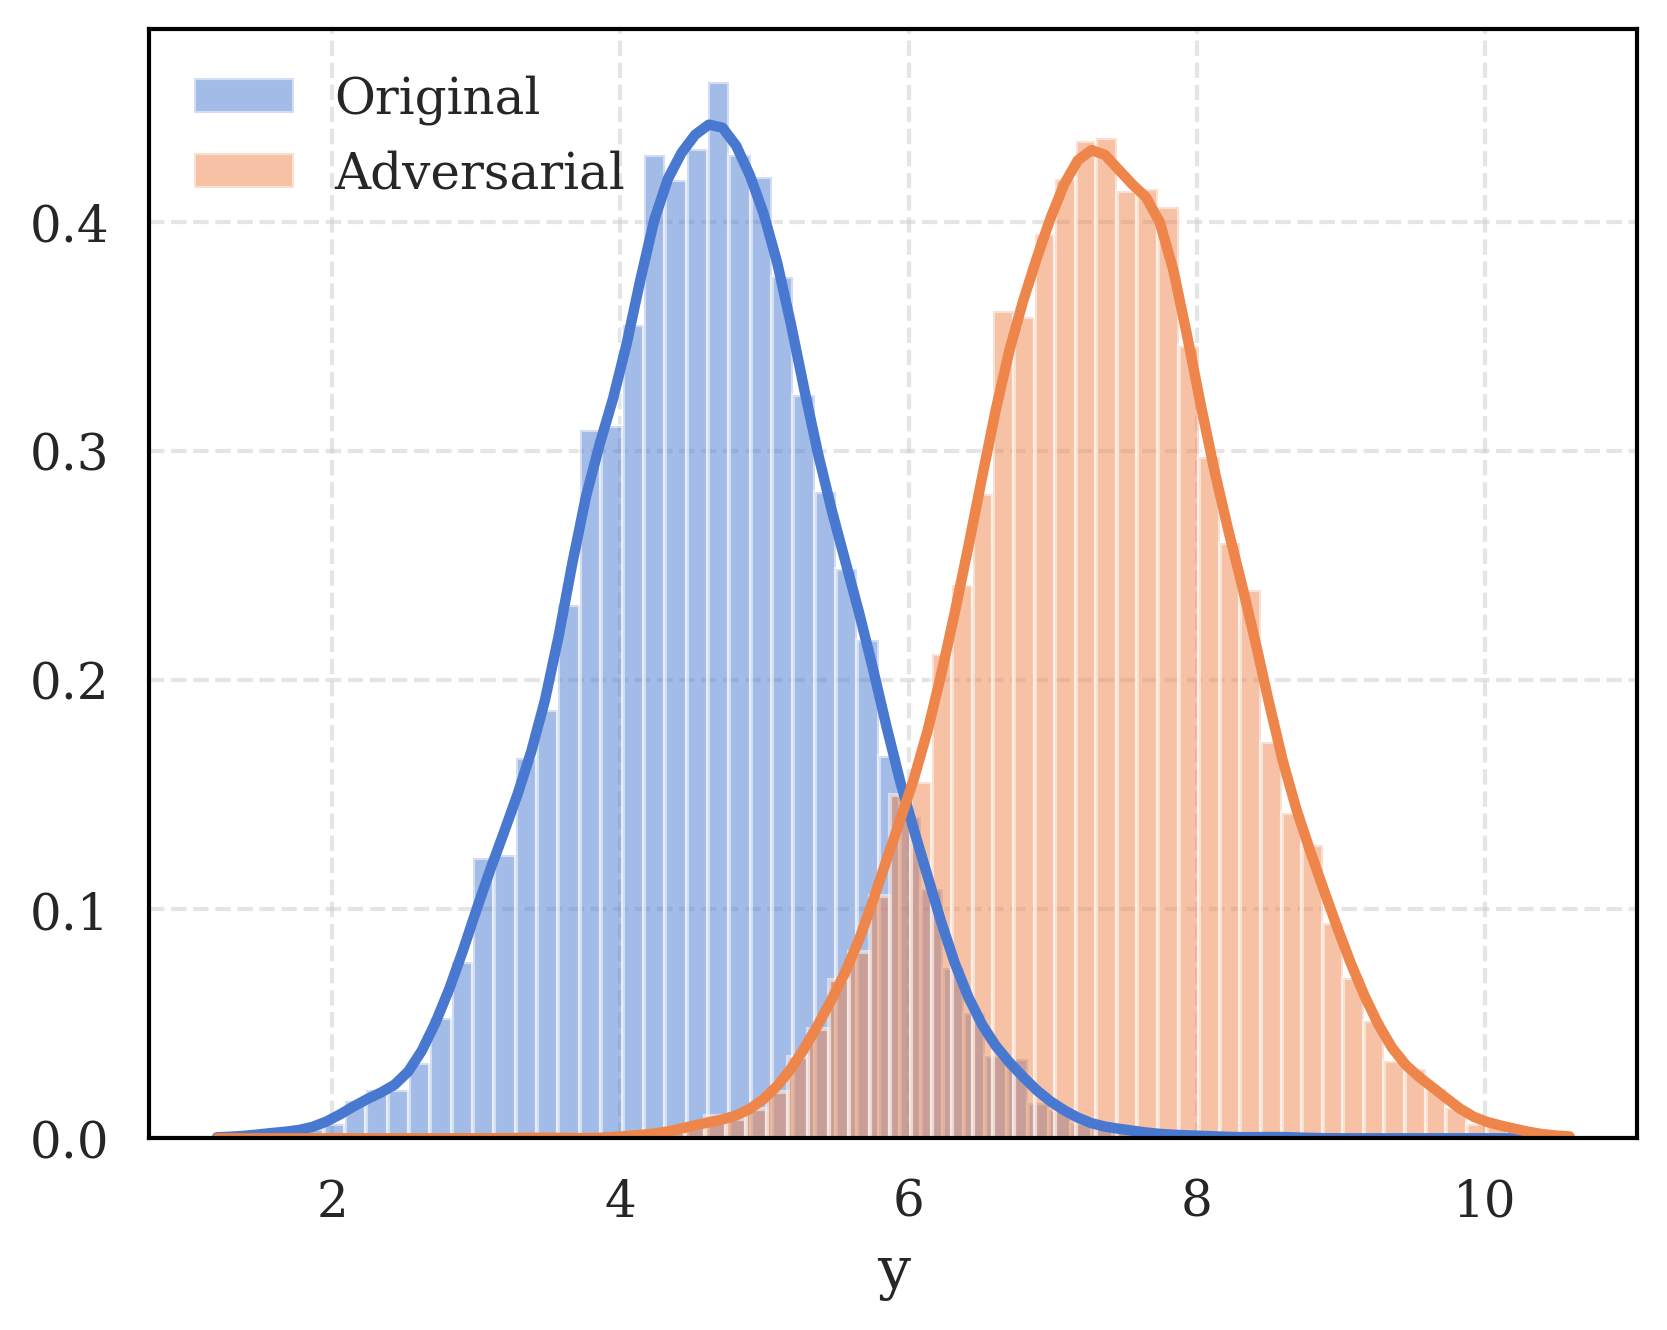

In [13]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_distr, x_adv_values = mlmc_attack(model, x, epsilon=.3, R=100, lr=0.01, n_iter=200)
plot_ppds(model, x, x_adv_distr)

<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2939908/120536183.py:27: SyntaxWarning: invalid escape sequence '\e'
  ax.set_title(f'$\epsilon=${epsilon:.2f}')


0
Early stopping at iteration 13
1
Early stopping at iteration 12
2
Early stopping at iteration 14
3
Early stopping at iteration 14
4
Early stopping at iteration 14
5
Early stopping at iteration 14
6
Early stopping at iteration 12
7
Early stopping at iteration 15
8
Early stopping at iteration 16
9
Early stopping at iteration 17


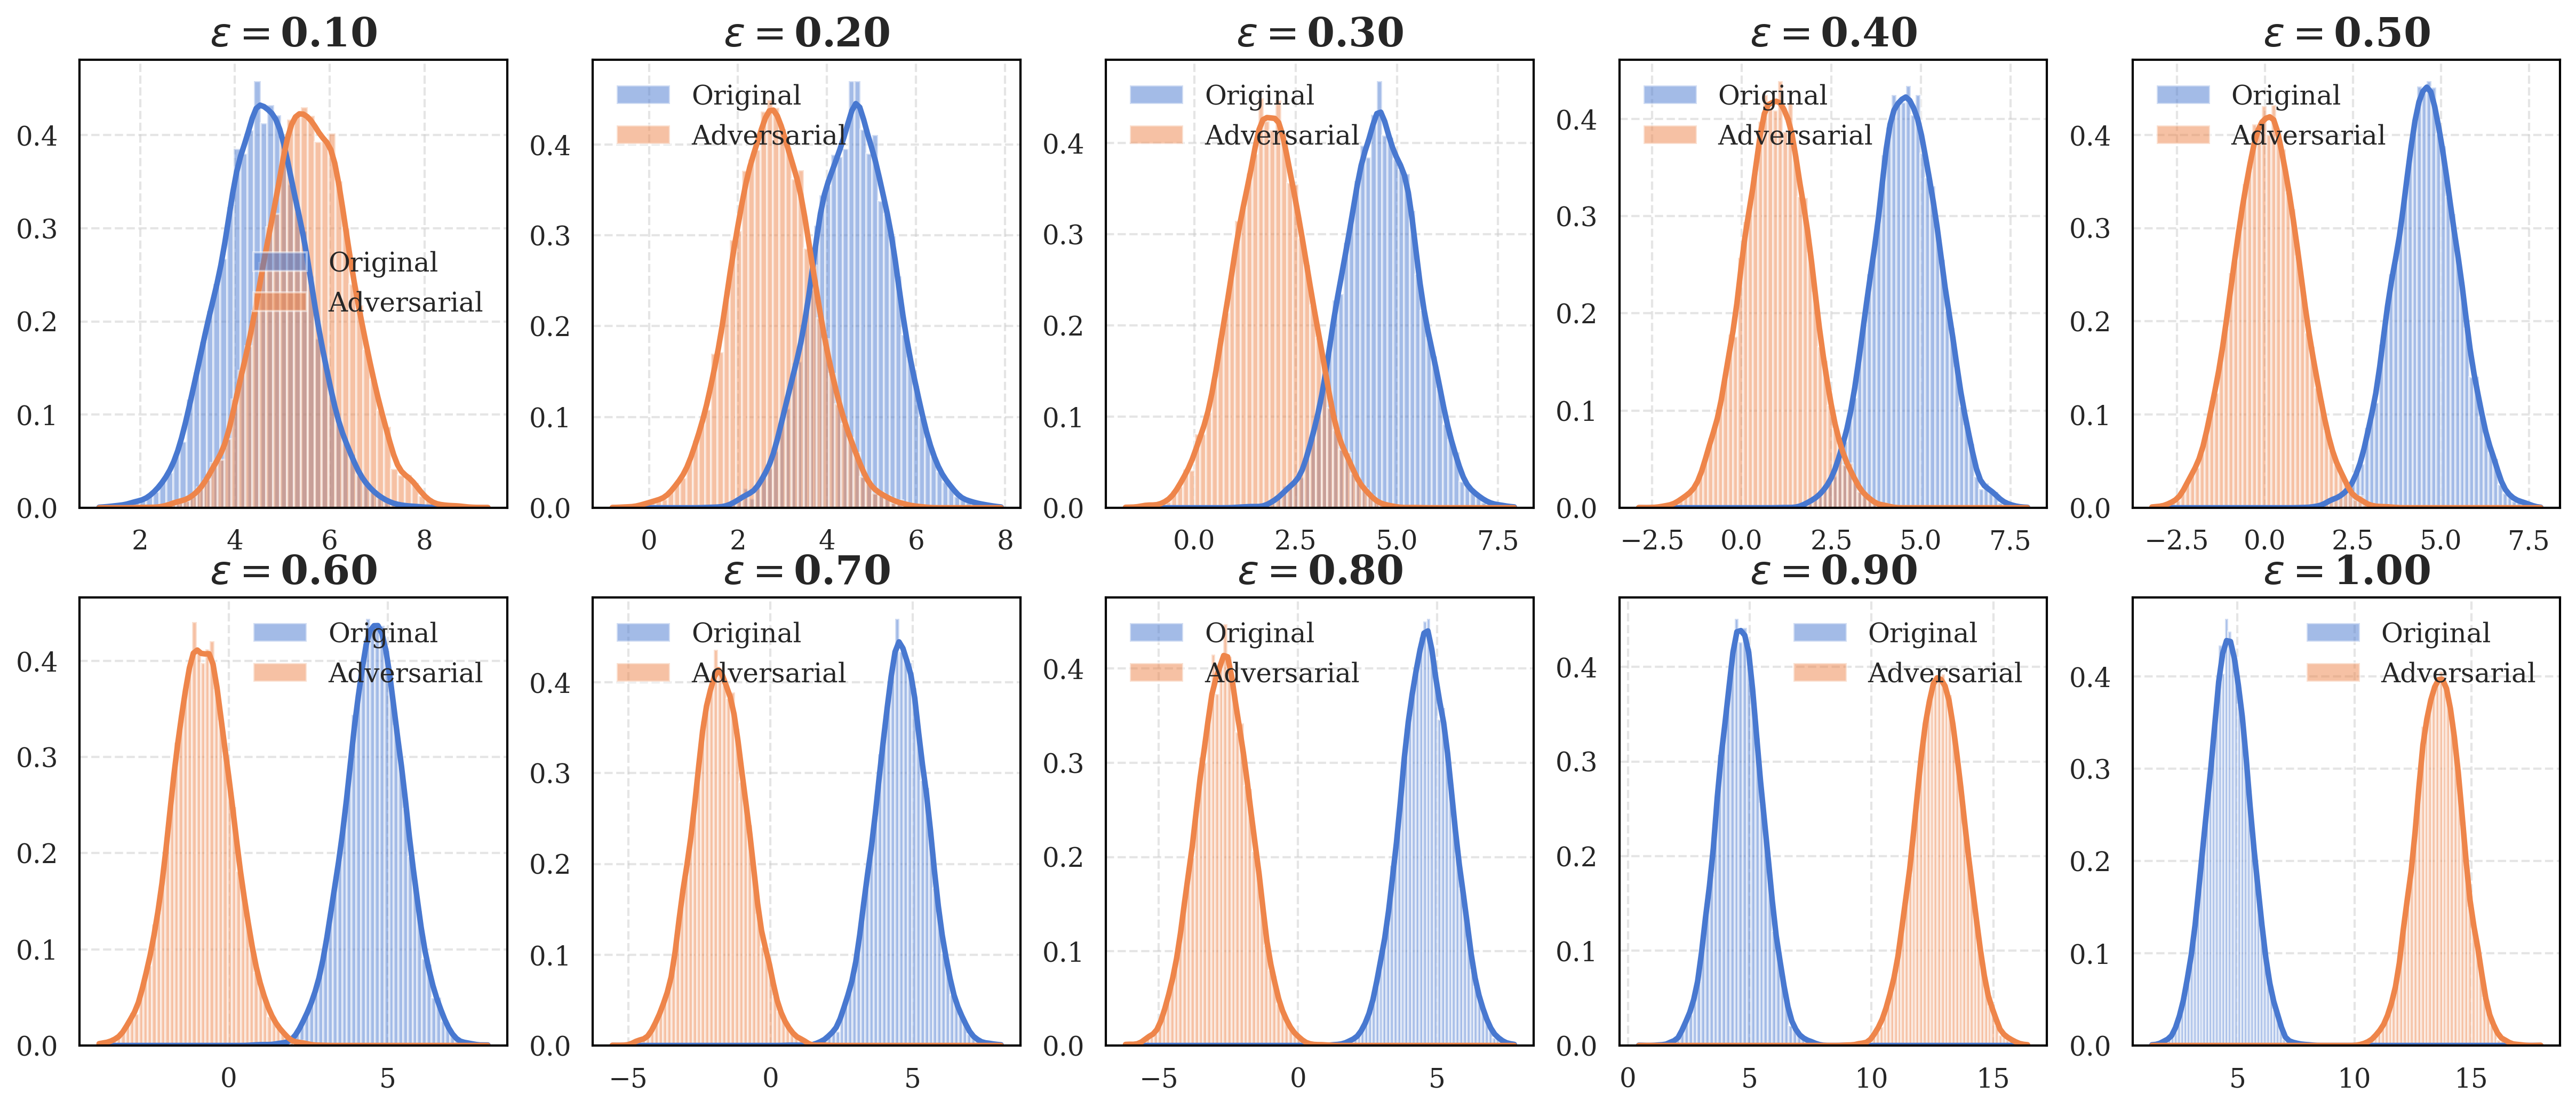

In [14]:
# Plot the histogram for 10 different epsilon values as subplots
epsilons = np.linspace(0.1, 1, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, epsilon in enumerate(epsilons):
    print(i)
    x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon)
    ax = axs[i // 5, i % 5]

    y_samples = model.sample_predictive_distribution(x, num_samples=10000).numpy()
    y_adv_samples = model.sample_predictive_distribution(x_adv_distr, num_samples=10000).numpy()

    kde = gaussian_kde(y_samples.T)
    kde_adv = gaussian_kde(y_adv_samples.T)

    ax.hist(y_samples, bins=50, alpha=0.5, label='Original', density=True)
    ax.hist(y_adv_samples, bins=50, alpha=0.5, label='Adversarial', density=True)

    ys = np.linspace(
        min(np.min(y_samples), np.min(y_adv_samples)), 
        max(np.max(y_samples), np.max(y_adv_samples)), 
        100)
    # plot with same color and label
    ax.plot(ys, kde(ys), color='C0')
    ax.plot(ys, kde_adv(ys), color='C1')
    ax.legend()

    ax.set_title(f'$\epsilon=${epsilon:.2f}')

In [15]:
# # Plot values evolution for the adversarial attack
# kl_proxies = []
# for x_adv in x_adv_values:
#     y_samples = model.sample_predictive_distribution(torch.tensor(x, dtype=torch.float32), num_samples=100)
#     val = -torch.mean(torch.log(pi(y_samples, torch.tensor(x_adv, dtype=torch.float32), model.sample_posterior_distribution(100))))
#     kl_proxies.append(val.item())
# 
# plt.plot(kl_proxies)

In [16]:
# n_jobs = -1
# 
# # queremos maximizar E_y[ -\log \pi(y | x', D)] con y \sim p(y | x, D)
# 
# # Function to calculate KL divergence for a given epsilon
# def compute_kl_divergence(epsilon):
#     x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon, R=100)
#     x_fsgm = fgsm_attack(model, x, epsilon=epsilon, R=100)
#     y_samples = model.sample_predictive_distribution(x, num_samples=100)
#     val = -torch.mean(torch.log(pi(y_samples, x_adv_distr, model.sample_posterior_distribution(100))))
#     val_fsgm = -torch.mean(torch.log(pi(y_samples, x_fsgm, model.sample_posterior_distribution(100))))
#     return val, val_fsgm
# 
# kl_alls = []
# # Define the range of epsilon values
# epsilons = np.linspace(0, 1, 20)
# 
# for _ in range(10):
#     # Use joblib to parallelize the computation of KL divergences
#     kl_values = Parallel(n_jobs=n_jobs)(
#         delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons
#     )
#     kl_alls.append(kl_values)
# 
# kl_mlmc = np.array(kl_alls)[:, :, 0]
# kl_fsgm = np.array(kl_alls)[:, :, 1]
# # error bars as std
# plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
# plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
# plt.legend()
# plt.xlabel('$\epsilon$')
# plt.ylabel('Proxy of KL Divergence')

### Case 2b: Same model as case 1

In [17]:
# Fit the model
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [18]:
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
lr = 0.0
mu_n = model.mu
lam_n = model.lam
sigma2 = model.sigma2
x_adv = (x + torch.randn_like(x) * 0.01).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
optimizer = SGD([x_adv], lr=0.0)
x_adv.requires_grad = True
optimizer.zero_grad()

kl = - kl_div(mu_n, lam_n, sigma2, x, x_adv)  # maximum disruption problem
kl.backward()
real_grad = x_adv.grad.clone().detach()

(array([155., 168., 141., 103., 100.,  86.,  67.,  54.,  46.,  15.,  26.,
         11.,  11.,   9.,   2.,   2.,   0.,   2.,   0.,   2.]),
 array([1.56620611e-02, 1.79488136e+00, 3.57410066e+00, 5.35331996e+00,
        7.13253926e+00, 8.91175856e+00, 1.06909779e+01, 1.24701972e+01,
        1.42494165e+01, 1.60286358e+01, 1.78078551e+01, 1.95870744e+01,
        2.13662937e+01, 2.31455130e+01, 2.49247323e+01, 2.67039516e+01,
        2.84831709e+01, 3.02623902e+01, 3.20416095e+01, 3.38208288e+01,
        3.56000481e+01]),
 <BarContainer object of 20 artists>)

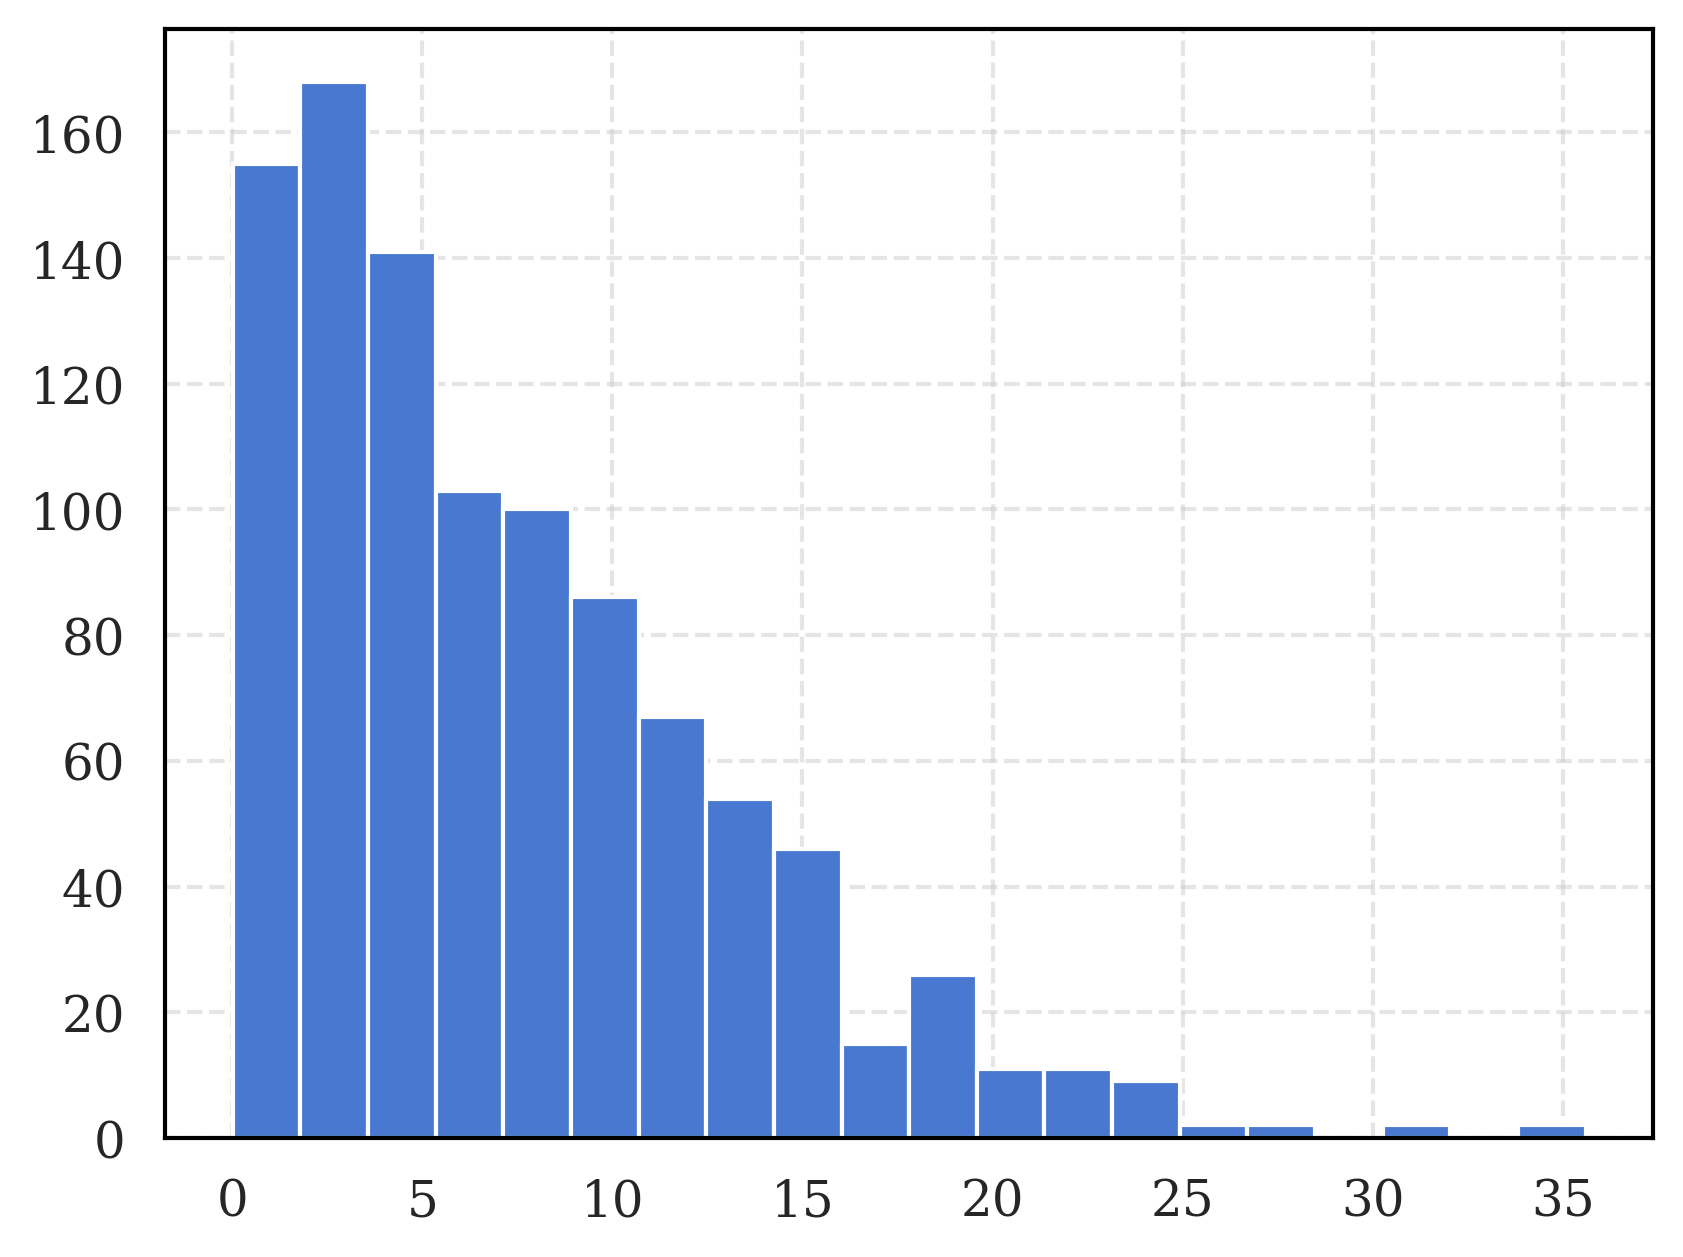

In [19]:
norms = []
for it in range(1000):
    y = model.sample_predictive_distribution(x, num_samples=1)
    gradient_estimate = mlmc_gradient_estimator(y, x_adv, 100, model, M0=2, tau=1)
    norms.append(torch.norm(real_grad - gradient_estimate).detach().item())
        
plt.hist(norms, bins=20)

In [20]:
# same as before but estimate the gradient doing the mean of 1000 iterations and doing it in paralell with joblib

def compute_norms(it):
    y = model.sample_predictive_distribution(x, num_samples=1)
    gradient_estimate = mlmc_gradient_estimator(y, x_adv, 100, model, M0=2, tau=1).clone().detach()
    for _ in range(100):
        y = model.sample_predictive_distribution(x, num_samples=1)
        gradient_estimate = mlmc_gradient_estimator(y, x_adv, 100, model, M0=2, tau=1).clone().detach()
        gradient_estimate += gradient_estimate
    gradient_estimate /= 101
    return torch.norm(real_grad - gradient_estimate).detach().item()

n_jobs = 66
norms = Parallel(n_jobs=n_jobs)(delayed(compute_norms)(i) for i in range(1000))
plt.hist(norms, bins=20)

/home/pgarcia/anaconda3/envs/advReg/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Long gradient estimation time: 5.4592039585113525 for iteration 0
Long gradient estimation time: 2.157602071762085 for iteration 50
Early stopping at iteration 460


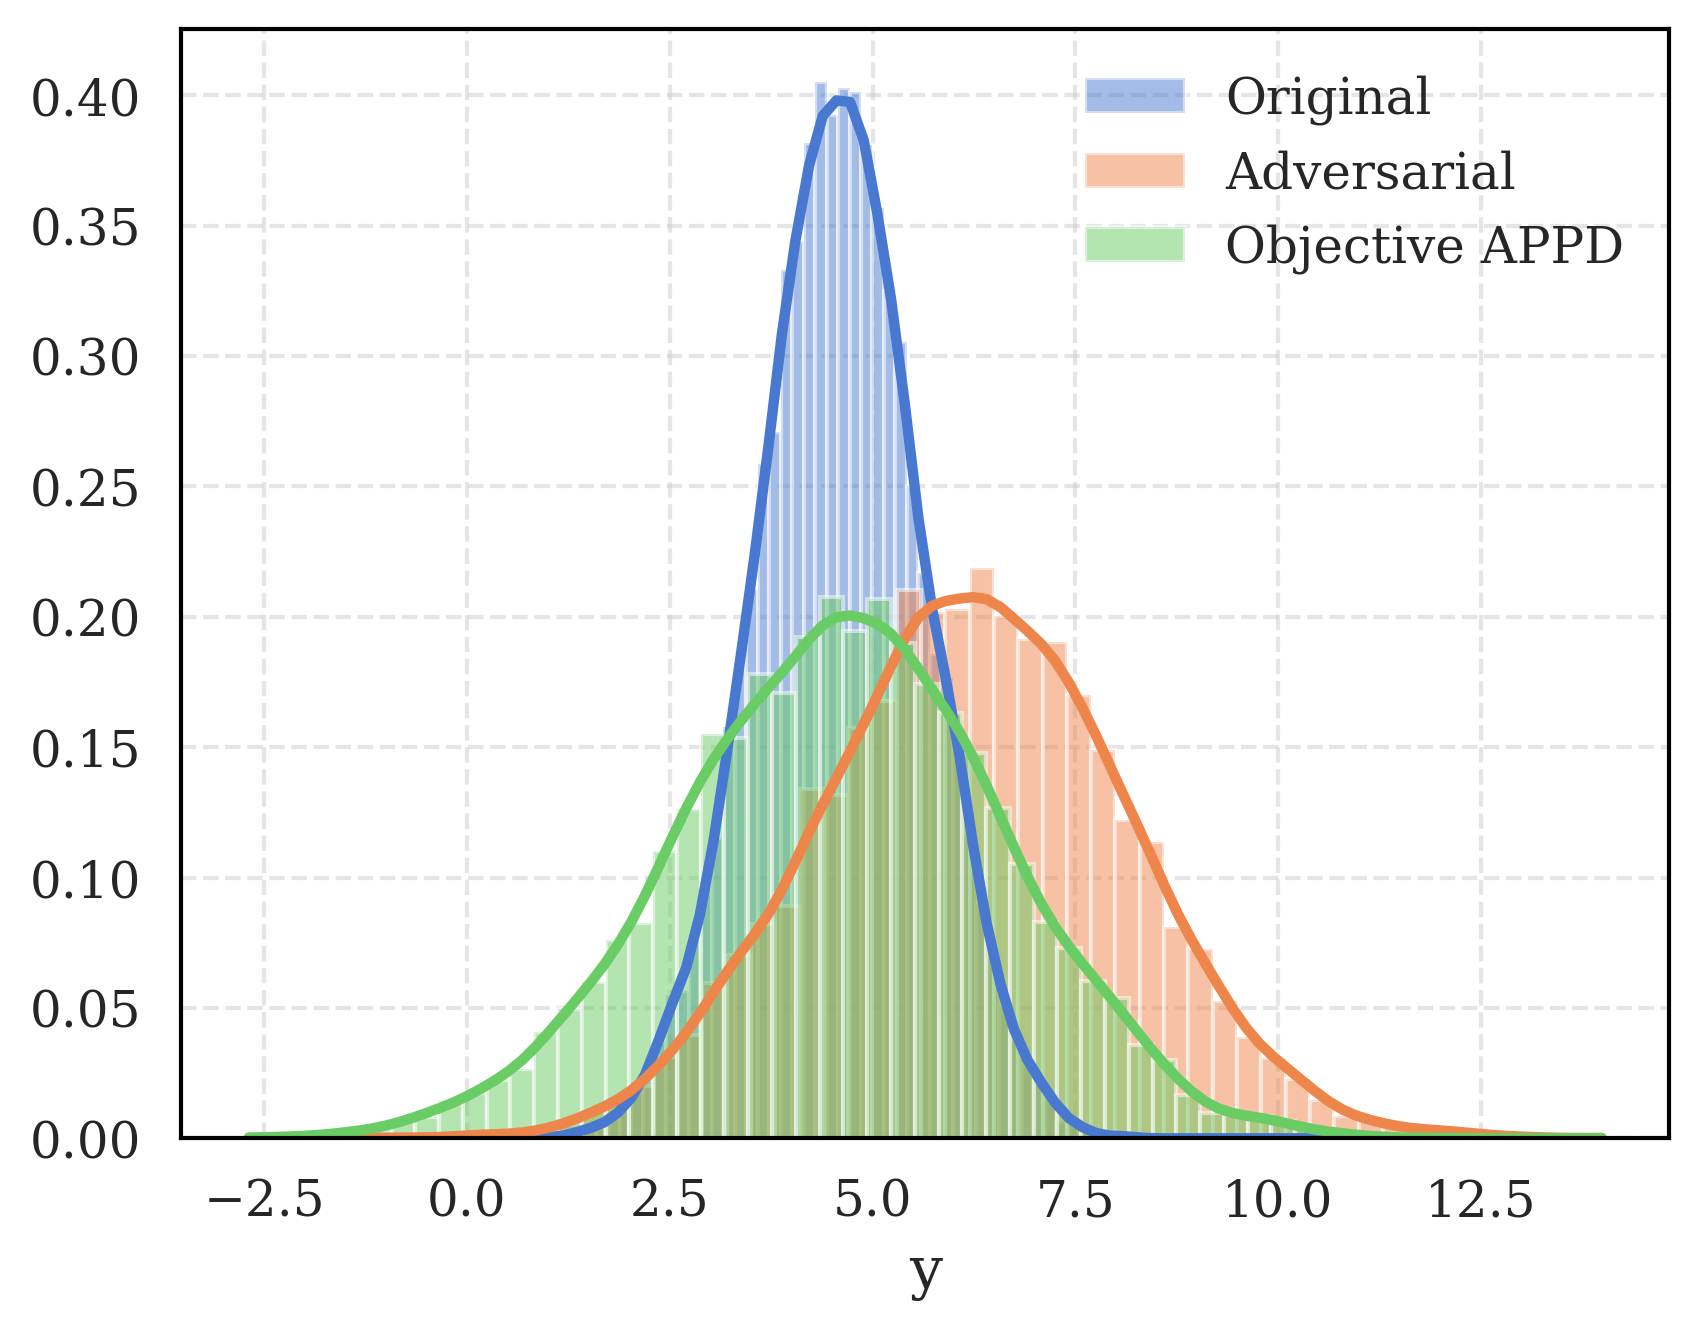

In [21]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
sigma2 = model.sample_posterior_distribution(1000)[1].mean()
appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * sigma2)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2)
plot_ppds(model, x, x_adv_distr, appd)

Early stopping at iteration 350


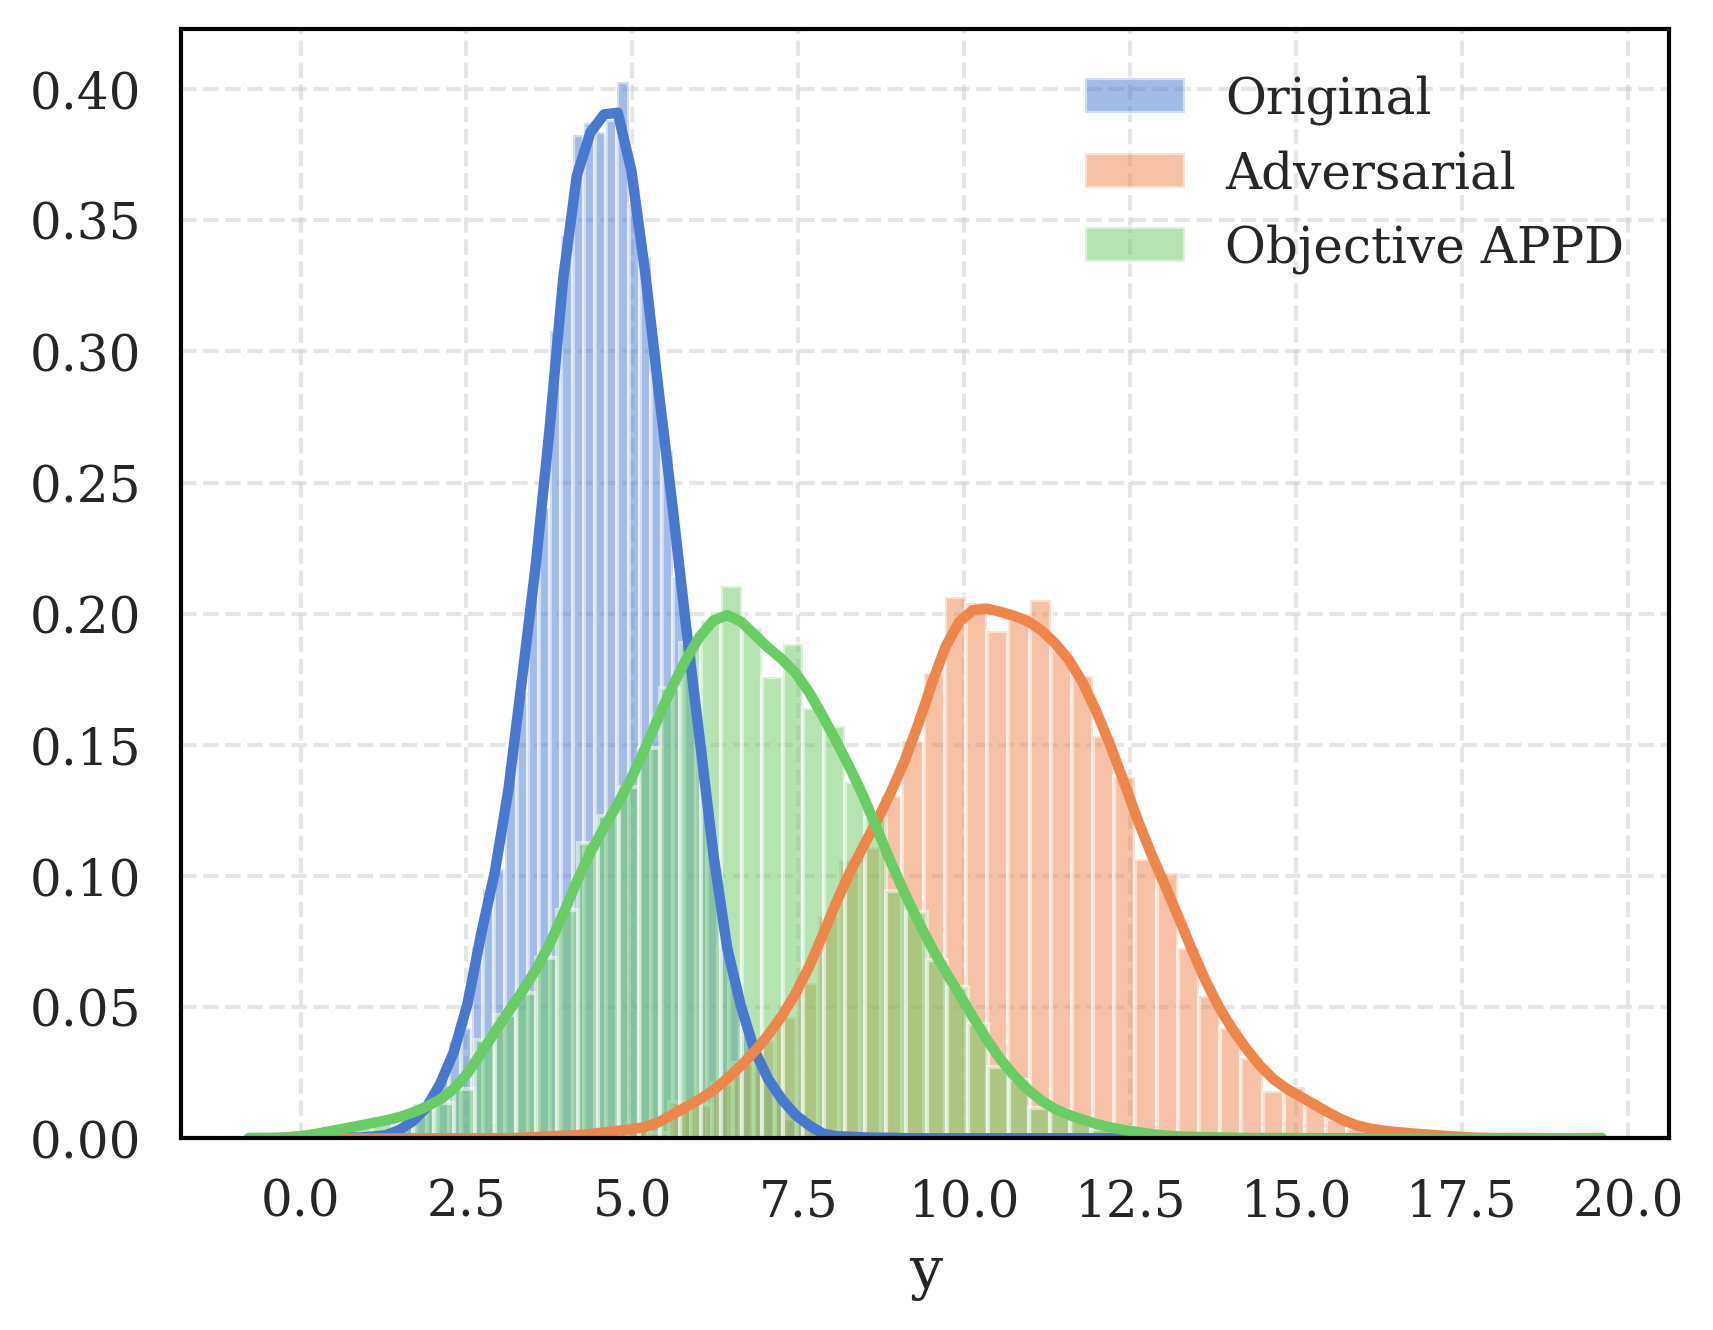

In [22]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
sigma2 = model.sample_posterior_distribution(1000)[1].mean()
appd = torch.distributions.normal.Normal(2 + x.T @ model.mu, 2 * sigma2)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2)
plot_ppds(model, x, x_adv_distr, appd)

Early stopping at iteration 12


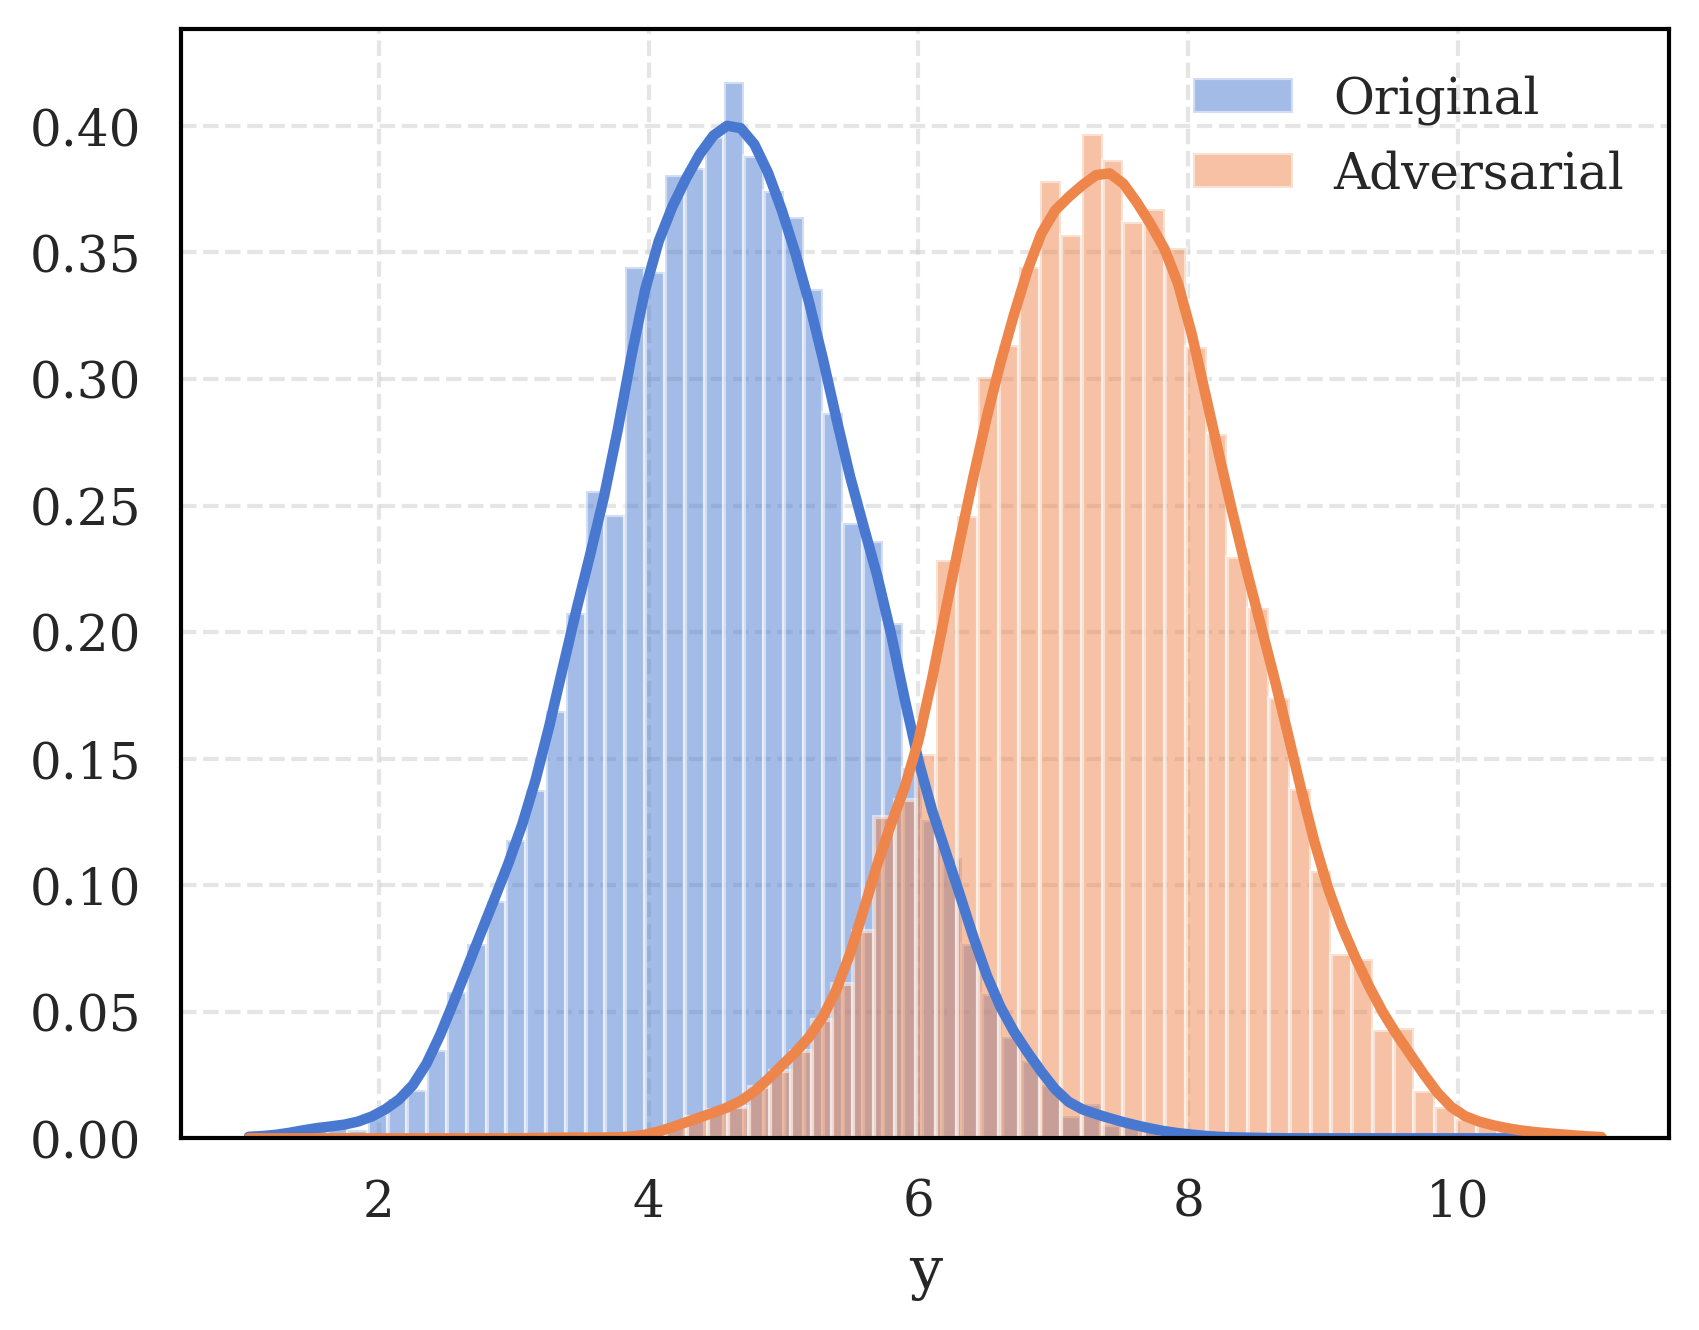

In [23]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_distr, x_adv_values = mlmc_attack(model, x, epsilon=0.3)
plot_ppds(model, x, x_adv_distr)

<>:30: SyntaxWarning: invalid escape sequence '\e'
<>:30: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_1606487/1651214978.py:30: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 15
Early stopping at iteration 16
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 13
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14
Early stopping at iteration 14
Early st

Text(0, 0.5, 'KL Divergence')

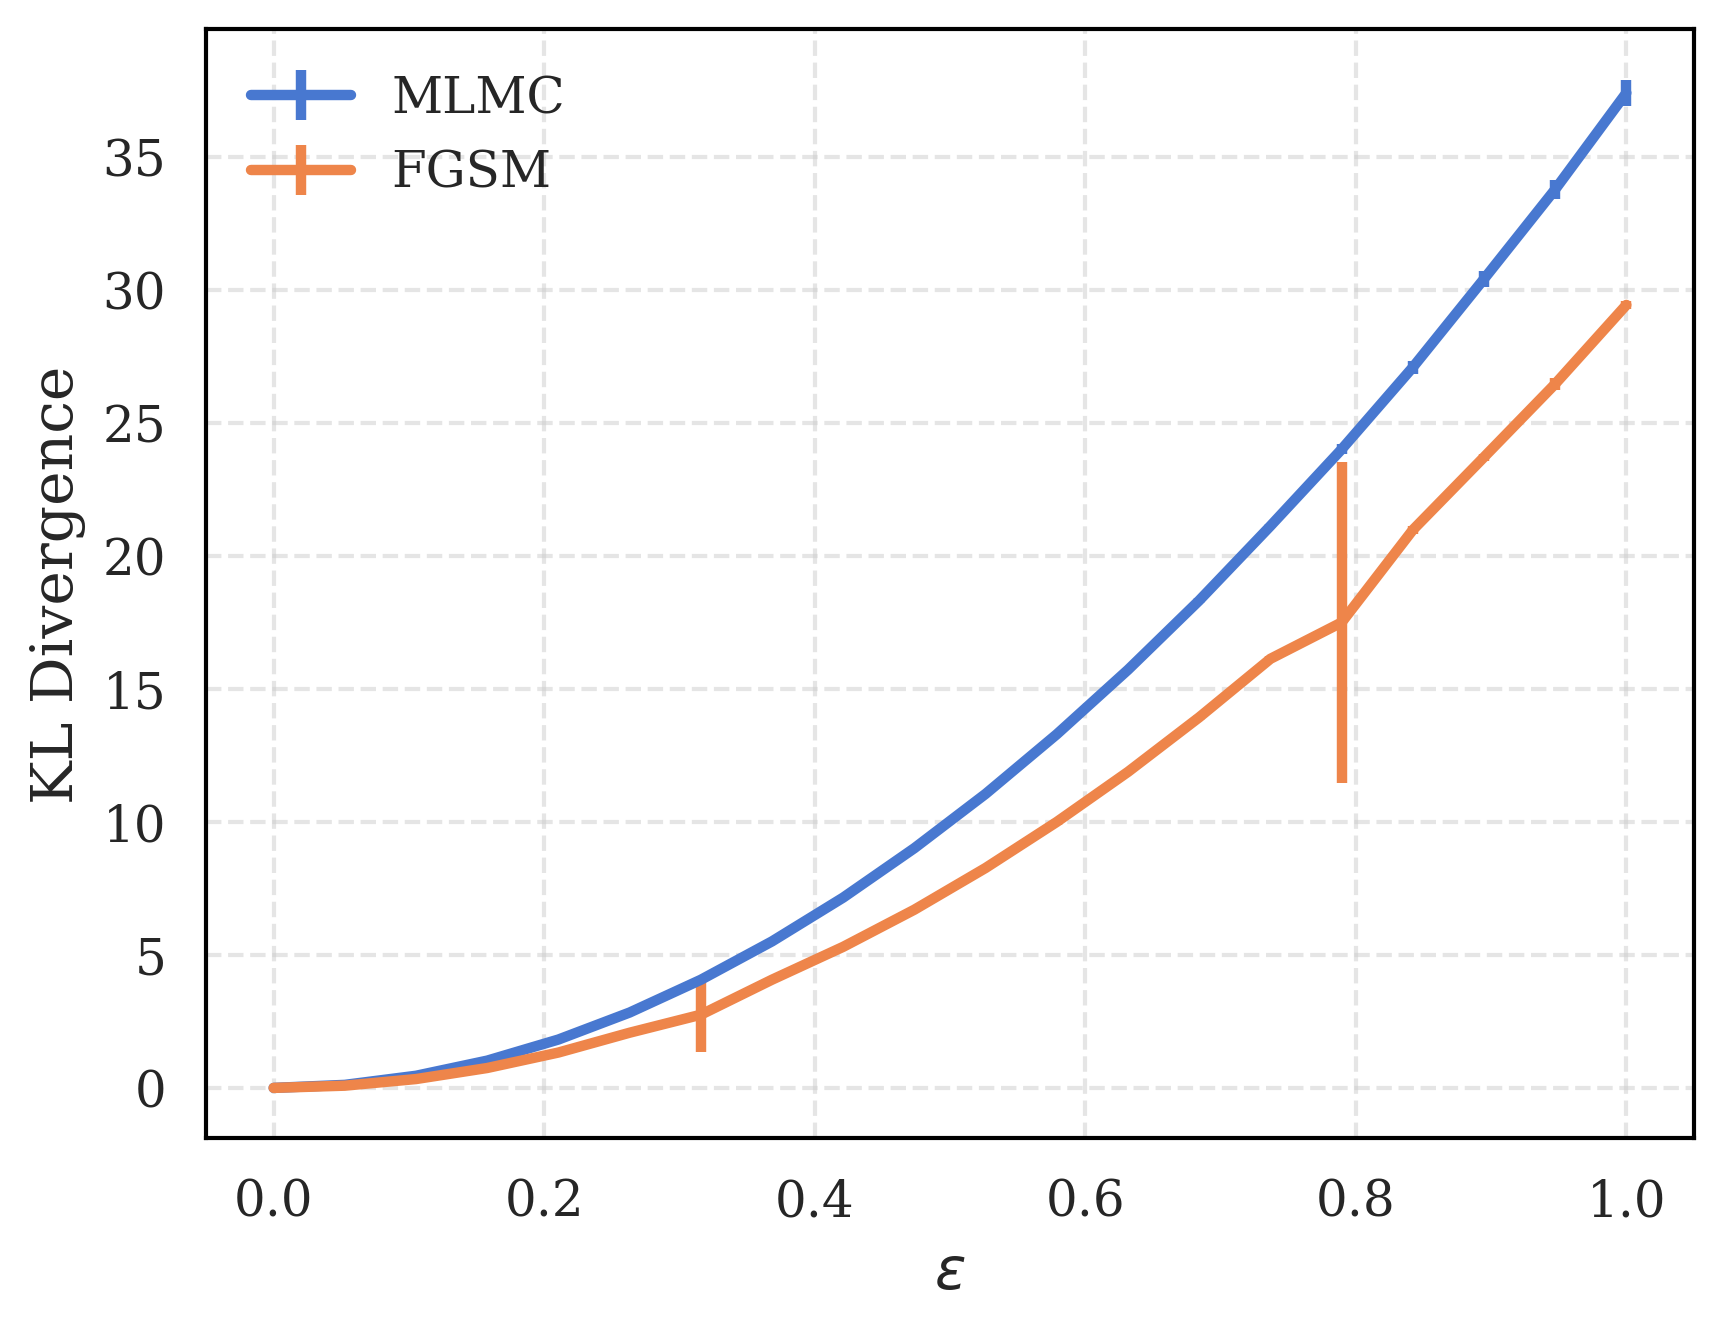

In [24]:
# plot KL divergence as a function of the strength of the attack
n_jobs = 66

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon, R=100)
    kl = kl_div(model.mu, model.lam, model.sigma2, x, x_adv_distr).item()
    x_fsgm = fgsm_attack(model, x, epsilon=epsilon, R=100)
    kl_fsgm = kl_div(model.mu, model.lam, model.sigma2, x, x_fsgm).item()
    return kl, kl_fsgm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
# error bars as std
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')

# Comparison of 3 datasets: Wine, energy and housing

In [4]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
data = pd.read_excel(url)

# The last two columns are the target variables (Heating Load and Cooling Load)
X = data.iloc[:, :-2].values  # Covariates
y = data.iloc[:, -2].values  # Heating Load

# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_energy_train, X_energy_test, y_energy_train, y_energy_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [6]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [8]:
# Housing dataset
california_housing = fetch_california_housing(as_frame=True)

X = california_housing.data.values
y = california_housing.target.values

X_normalized = MinMaxScaler().fit_transform(X)

X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [11]:
# For all 3 datasets: Fit the model, compute the average rmse over the test set for the original data and the adversarial examples with epsilon = 0.2 and epsilon = 0.5
datasets = ['housing', 'energy', 'wine']
epsilons = [0, 0.2, 0.5]

results = []

for dataset in datasets:
    print(f'Running dataset {dataset}')
    if dataset == 'energy':
        X_train, X_test, y_train, y_test = X_energy_train, X_energy_test, y_energy_train, y_energy_test
    elif dataset == 'wine':
        X_train, X_test, y_train, y_test = X_wine_train, X_wine_test, y_wine_train, y_wine_test
    elif dataset == 'housing':
        X_train, X_test, y_train, y_test = X_housing_train, X_housing_test, y_housing_train, y_housing_test

    model = NormalInverseGammaPriorLinearRegression(prior_params={
        'mu': torch.zeros(X_train.shape[1]), 
        'lam': torch.eye(X_train.shape[1]), 
        'a': torch.tensor([10]), 
        'b': torch.tensor([1])}
        )
    data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
    model.fit(data)

    X_test = X_test[:100, :]
    y_test = y_test[:100]
    
    results_dataset = []
    for epsilon in epsilons:
        kl = 0
        def compute_kl(i):
            x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32).unsqueeze(1)
            if epsilon == 0:
                x_adv = x.clone().detach()
            else:
                x_adv, _ = mlmc_attack(model, x, epsilon=epsilon)
            sigma2 = model.sample_posterior_distribution(1000)[1].mean()
            return kl_div(model.mu, model.lam, sigma2, x, x_adv).item()

        kl_values = Parallel(n_jobs=-1)(delayed(compute_kl)(i) for i in range(X_test.shape[0]))
        kl = sum(kl_values)
        results_dataset.append(kl / X_test.shape[0])
    results.append(results_dataset)

Running dataset housing


/home/pgarcia/AdvReg/src/models/conjugate_bayes_lin_reg.py:119: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724788957849/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  b_n = self.b + 0.5 * (y.T @ y + self.mu.T @ self.lam @ self.mu - mu_n.T @ lam_n @ mu_n)


Long gradient estimation time: 2.2252769470214844 for iteration 0
Long gradient estimation time: 3.0279269218444824 for iteration 0
Long gradient estimation time: 2.2402873039245605 for iteration 0
Long gradient estimation time: 3.5212175846099854 for iteration 0
Long gradient estimation time: 2.6167726516723633 for iteration 1
Long gradient estimation time: 2.1636290550231934 for iteration 1
Long gradient estimation time: 2.025620698928833 for iteration 1
Long gradient estimation time: 4.11837363243103 for iteration 0
Long gradient estimation time: 3.4504826068878174 for iteration 1Long gradient estimation time: 2.9669151306152344 for iteration 0

Long gradient estimation time: 2.7161409854888916 for iteration 2
Long gradient estimation time: 3.6552376747131348 for iteration 1
Long gradient estimation time: 5.399458885192871 for iteration 0
Long gradient estimation time: 4.3566131591796875 for iteration 0
Long gradient estimation time: 2.160447835922241 for iteration 1
Long gradient e

/home/pgarcia/anaconda3/envs/advReg/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Long gradient estimation time: 2.3665482997894287 for iteration 0
Long gradient estimation time: 2.4418179988861084 for iteration 0
Long gradient estimation time: 2.959446907043457 for iteration 0
Long gradient estimation time: 2.670337677001953 for iteration 0
Long gradient estimation time: 3.476656913757324 for iteration 0
Long gradient estimation time: 2.1384620666503906 for iteration 1
Long gradient estimation time: 2.9890308380126953 for iteration 2
Long gradient estimation time: 2.132540702819824 for iteration 3
Long gradient estimation time: 2.1872034072875977 for iteration 4
Long gradient estimation time: 4.141249656677246 for iteration 1
Long gradient estimation time: 2.229323387145996 for iteration 2
Long gradient estimation time: 2.631822347640991 for iteration 2
Long gradient estimation time: 2.8704566955566406 for iteration 2
Long gradient estimation time: 2.312225818634033 for iteration 2
Long gradient estimation time: 5.258639335632324 for iteration 1
Long gradient estim

In [ ]:
# Display as a table
results_array = np.array(results)
results_array = np.round(results_array, 3)
results_df = pd.DataFrame(results_array, columns=epsilons, index=datasets)
results_df